In [ ]:
!pip install prophet dagshub scikit-learn pandas numpy mlflow==2.2.2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import itertools
import mlflow
import mlflow.sklearn
import dagshub
import os
from datetime import datetime
import pickle

warnings.filterwarnings('ignore')

In [ ]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'nipkha21'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '202fb8a4c58a90b0eb3598b1037498eb6fe9f593'

dagshub.init(repo_owner='TomC333', repo_name='ml-walmart-recruiting', mlflow=True)
mlflow.set_tracking_uri('https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow')

print("MLflow setup completed")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=3277e9c6-7f19-4bb9-bb38-211ac108d8aa&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=11221f8f74eeae3886fa1d64e1ead127a8e4137fe3400ecf1fcc2bb35c6e1494




Accessing as nipkha21

Initialized MLflow to track repo "TomC333/ml-walmart-recruiting"

Repository TomC333/ml-walmart-recruiting initialized!

MLflow setup completed


In [ ]:
print("Loading data...")
features_data = pd.read_csv('features.csv')
train_data = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')

print(f"Features data shape: {features_data.shape}")
print(f"Train data shape: {train_data.shape}")
print(f"Stores data shape: {stores.shape}")

df = train_data.merge(features_data, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')

if 'IsHoliday_y' in df.columns:
    df.drop(['IsHoliday_y'], axis=1, inplace=True)
    df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

print(f"Merged dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")


Loading data...
Features data shape: (8190, 12)
Train data shape: (421570, 5)
Stores data shape: (45, 3)
Merged dataset shape: (421570, 16)
Date range: 2010-02-05 to 2012-10-26


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Store', 'Dept', 'Date'])

print(f"Negative sales records: {len(df[df['Weekly_Sales'] < 0])}")
df = df[df['Weekly_Sales'] >= 0]

df['Is_SuperBowl'] = np.where(df['Date'].isin(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']), 1, 0)
df['Is_LaborDay'] = np.where(df['Date'].isin(['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']), 1, 0)
df['Is_Thanksgiving'] = np.where(df['Date'].isin(['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']), 1, 0)
df['Is_Christmas'] = np.where(df['Date'].isin(['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']), 1, 0)

external_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for col in external_cols:
    if col in df.columns:
        df[col] = df.groupby(['Store', 'Dept'])[col].ffill().bfill()

print("Feature engineering completed")
print(f"Holiday weeks: SuperBowl={df['Is_SuperBowl'].sum()}, LaborDay={df['Is_LaborDay'].sum()}, Thanksgiving={df['Is_Thanksgiving'].sum()}, Christmas={df['Is_Christmas'].sum()}")

Negative sales records: 1285
Feature engineering completed
Holiday weeks: SuperBowl=8874, LaborDay=8833, Thanksgiving=5946, Christmas=5910


In [ ]:
def check_stationarity(timeseries, title):
    """Check if time series is stationary using ADF test"""
    result = adfuller(timeseries.dropna())
    print(f'\nStationarity Test for {title}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    if result[1] <= 0.05:
        print("Result: Time series is stationary")
        return True
    else:
        print("Result: Time series is non-stationary")
        return False

def smart_sarima_order(ts, quick_search=True):
    """Smart SARIMA parameter selection - much faster"""
    if quick_search:
        param_combinations = [
            ((1,1,1), (1,1,1,52)),
            ((1,1,0), (1,1,0,52)),
            ((0,1,1), (0,1,1,52)),
            ((1,1,1), (0,1,1,52)),
            ((2,1,1), (1,1,1,52)),
            ((1,1,2), (1,1,1,52)),
        ]
    else:
        pass

    best_aic = np.inf
    best_order = (1,1,1)
    best_seasonal_order = (1,1,1,52)

    for order, seasonal_order in param_combinations:
        try:
            model = SARIMAX(ts, order=order, seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
            fitted_model = model.fit(disp=False)

            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

    return best_order, best_seasonal_order, best_aic

def fit_sarima_model(ts, order, seasonal_order, exog=None):
    """Fit SARIMA model with given parameters"""
    try:
        model = SARIMAX(ts, order=order, seasonal_order=seasonal_order,
                       exog=exog, enforce_stationarity=False, enforce_invertibility=False)
        fitted_model = model.fit(disp=False)
        return fitted_model
    except Exception as e:
        print(f"Error fitting SARIMA model: {e}")
        return None

def evaluate_sarima_model(fitted_model, test_data, exog_test=None):
    """Evaluate SARIMA model performance"""
    try:
        if exog_test is not None:
            forecast = fitted_model.forecast(steps=len(test_data), exog=exog_test)
        else:
            forecast = fitted_model.forecast(steps=len(test_data))

        mae = mean_absolute_error(test_data, forecast)
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        mape = np.mean(np.abs((test_data - forecast) / np.maximum(test_data, 1e-8))) * 100

        return mae, rmse, mape, forecast
    except Exception as e:
        print(f"Error evaluating model: {e}")
        return None, None, None, None

print("✅ SARIMA helper functions defined")

✅ SARIMA helper functions defined


In [ ]:
def prepare_sarima_data(data, store, dept, exog_vars=None):
    """Prepare time series data for SARIMA modeling"""
    combo_data = data[(data['Store'] == store) & (data['Dept'] == dept)].copy()
    combo_data = combo_data.sort_values('Date')

    if len(combo_data) < 20:
        return None, None, None, None

    ts = combo_data.set_index('Date')['Weekly_Sales']

    exog = None
    if exog_vars:
        available_vars = [var for var in exog_vars if var in combo_data.columns]
        if available_vars:
            exog = combo_data.set_index('Date')[available_vars]

    return ts, exog, len(combo_data), combo_data

def train_sarima_model(ts, exog, order, seasonal_order, train_ratio=0.8):
    """Train and evaluate SARIMA model"""
    try:
        train_size = int(len(ts) * train_ratio)
        train_ts = ts[:train_size]
        test_ts = ts[train_size:]

        train_exog = None
        test_exog = None
        if exog is not None:
            train_exog = exog[:train_size]
            test_exog = exog[train_size:]

        fitted_model = fit_sarima_model(train_ts, order, seasonal_order, train_exog)
        if fitted_model is None:
            return None, None, None, None, None

        mae, rmse, mape, forecast = evaluate_sarima_model(fitted_model, test_ts, test_exog)
        if mae is None:
            return None, None, None, None, None

        return fitted_model, mae, rmse, mape, forecast

    except Exception as e:
        print(f"Error in SARIMA training: {e}")
        return None, None, None, None, None

print("✅ SARIMA training functions defined")

✅ SARIMA training functions defined


In [ ]:
MIN_DATA_POINTS = 20
TRAIN_RATIO = 0.8

phases = {
    "Phase1_SARIMA_Simple": {
        "description": "Simple SARIMA (1,1,1)×(1,1,1,52)",
        "order": (1, 1, 1),
        "seasonal_order": (1, 1, 1, 52),
        "exog_vars": None,
        "auto_params": False
    },
    "Phase2_SARIMA_NoMA": {
        "description": "SARIMA without MA terms",
        "order": (1, 1, 0),
        "seasonal_order": (1, 1, 0, 52),
        "exog_vars": None,
        "auto_params": False
    },
    "Phase3_SARIMA_External": {
        "description": "Simple SARIMA with external variables",
        "order": (1, 1, 1),
        "seasonal_order": (1, 1, 1, 52),
        "exog_vars": ['Temperature', 'Fuel_Price'],
        "auto_params": False
    },
    "Phase4_SARIMA_Holidays": {
        "description": "Simple SARIMA with holidays",
        "order": (1, 1, 1),
        "seasonal_order": (1, 1, 1, 52),
        "exog_vars": ['IsHoliday'],
        "auto_params": False
    },
    "Phase5_SARIMA_Smart": {
        "description": "Smart parameter selection (6 combinations)",
        "order": "smart",
        "seasonal_order": "smart",
        "exog_vars": None,
        "auto_params": True
    }
}
print("Defined 6 phases for iterative SARIMA feature testing:")
for phase, config in phases.items():
    print(f"  {phase}: {config['description']}")

Defined 6 phases for iterative SARIMA feature testing:
  Phase1_SARIMA_Simple: Simple SARIMA (1,1,1)×(1,1,1,52)
  Phase2_SARIMA_NoMA: SARIMA without MA terms
  Phase3_SARIMA_External: Simple SARIMA with external variables
  Phase4_SARIMA_Holidays: Simple SARIMA with holidays
  Phase5_SARIMA_Smart: Smart parameter selection (6 combinations)


In [ ]:
store_dept_combinations = df.groupby(['Store', 'Dept']).size().reset_index(name='count')
valid_combinations = store_dept_combinations[store_dept_combinations['count'] >= MIN_DATA_POINTS][['Store', 'Dept']]

print(f"Total store-dept combinations: {len(store_dept_combinations)}")
print(f"Valid combinations (>= {MIN_DATA_POINTS} data points): {len(valid_combinations)}")

valid_combinations = valid_combinations.head(50)
print(f"Running on first {len(valid_combinations)} combinations for testing")

Total store-dept combinations: 3323
Valid combinations (>= 20 data points): 3071
Running on first 50 combinations for testing


In [ ]:
mlflow.set_experiment("Sales_Forecasting_SARIMA")

all_results = {}
phase_comparison = []

for phase_name, phase_config in phases.items():
    print(f"\n{'='*60}")
    print(f"PHASE: {phase_name}")
    print(f"Description: {phase_config['description']}")
    print(f"Order: {phase_config['order']}")
    print(f"Seasonal Order: {phase_config['seasonal_order']}")
    print(f"Exogenous Variables: {phase_config['exog_vars']}")
    print(f"{'='*60}")

    phase_results = []
    successful_models = 0
    failed_models = 0

    with mlflow.start_run(run_name=f"SARIMA_{phase_name}"):

        mlflow.log_param("phase_name", phase_name)
        mlflow.log_param("order", str(phase_config['order']))
        mlflow.log_param("seasonal_order", str(phase_config['seasonal_order']))
        mlflow.log_param("exog_vars", str(phase_config['exog_vars']))
        mlflow.log_param("auto_params", phase_config['auto_params'])
        mlflow.log_param("total_combinations", len(valid_combinations))
        mlflow.log_param("min_data_points", MIN_DATA_POINTS)
        mlflow.log_param("train_ratio", TRAIN_RATIO)

        for idx, row in valid_combinations.iterrows():
            store, dept = row['Store'], row['Dept']

            ts, exog, data_size, combo_data = prepare_sarima_data(
                df, store, dept, phase_config['exog_vars']
            )

            if ts is None:
                failed_models += 1
                continue

            if phase_config['auto_params']:
              print(f"Smart parameter selection for Store {store}, Dept {dept}...")
              try:
                order, seasonal_order, aic = smart_sarima_order(ts, quick_search=True)
              except:
                print('falling back')
                order = (1, 1, 1)
                seasonal_order = (1, 1, 1, 52)
            else:
                order = phase_config['order']
                seasonal_order = phase_config['seasonal_order']

            fitted_model, mae, rmse, mape, forecast = train_sarima_model(
                ts, exog, order, seasonal_order, TRAIN_RATIO
            )

            if fitted_model is not None and mae is not None:
                phase_results.append({
                    'Store': store,
                    'Dept': dept,
                    'MAE': mae,
                    'RMSE': rmse,
                    'MAPE': mape,
                    'Data_Size': data_size,
                    'Order': str(order),
                    'Seasonal_Order': str(seasonal_order),
                    'AIC': fitted_model.aic
                })
                successful_models += 1

                if successful_models % 10 == 0:
                    print(f"Completed {successful_models} models...")
            else:
                failed_models += 1

        if phase_results:
            results_df = pd.DataFrame(phase_results)

            mlflow.log_metric("successful_models", successful_models)
            mlflow.log_metric("failed_models", failed_models)
            mlflow.log_metric("avg_mae", results_df['MAE'].mean())
            mlflow.log_metric("avg_rmse", results_df['RMSE'].mean())
            mlflow.log_metric("avg_mape", results_df['MAPE'].mean())
            mlflow.log_metric("median_mae", results_df['MAE'].median())
            mlflow.log_metric("median_rmse", results_df['RMSE'].median())
            mlflow.log_metric("median_mape", results_df['MAPE'].median())
            mlflow.log_metric("std_mae", results_df['MAE'].std())
            mlflow.log_metric("std_rmse", results_df['RMSE'].std())
            mlflow.log_metric("std_mape", results_df['MAPE'].std())
            mlflow.log_metric("avg_aic", results_df['AIC'].mean())

            phase_summary = {
                'Phase': phase_name,
                'Description': phase_config['description'],
                'Avg_MAE': results_df['MAE'].mean(),
                'Median_MAE': results_df['MAE'].median(),
                'Avg_RMSE': results_df['RMSE'].mean(),
                'Avg_MAPE': results_df['MAPE'].mean(),
                'Successful_Models': successful_models,
                'Failed_Models': failed_models,
                'Avg_AIC': results_df['AIC'].mean()
            }
            phase_comparison.append(phase_summary)

            print(f"\nPHASE {phase_name} RESULTS:")
            print(f"Successful models: {successful_models}")
            print(f"Failed models: {failed_models}")
            print(f"Average MAE: {results_df['MAE'].mean():.2f}")
            print(f"Median MAE: {results_df['MAE'].median():.2f}")
            print(f"Average RMSE: {results_df['RMSE'].mean():.2f}")
            print(f"Average MAPE: {results_df['MAPE'].mean():.2f}%")
            print(f"Average AIC: {results_df['AIC'].mean():.2f}")

            all_results[phase_name] = results_df

        run_id = mlflow.active_run().info.run_id
        print(f"Phase {phase_name} logged with run_id: {run_id}")

print(f"\nAll SARIMA phases completed!")


PHASE: Phase1_SARIMA_Simple
Description: Simple SARIMA (1,1,1)×(1,1,1,52)
Order: (1, 1, 1)
Seasonal Order: (1, 1, 1, 52)
Exogenous Variables: None
Completed 10 models...
Completed 20 models...
Completed 30 models...
Completed 40 models...


Completed 50 models...

PHASE Phase1_SARIMA_Simple RESULTS:
Successful models: 50
Failed models: 0
Average MAE: 1303101264229.66
Median MAE: 1274.44
Average RMSE: 4395868174951.63
Average MAPE: 5596476664.37%
Average AIC: 113.04
Phase Phase1_SARIMA_Simple logged with run_id: ff30053ea0ca4576acf78875067d3bf6

PHASE: Phase2_SARIMA_NoMA
Description: SARIMA without MA terms
Order: (1, 1, 0)
Seasonal Order: (1, 1, 0, 52)
Exogenous Variables: None
Completed 10 models...
Completed 20 models...
Completed 30 models...
Completed 40 models...
Error evaluating model: Input contains NaN.

PHASE Phase2_SARIMA_NoMA RESULTS:
Successful models: 49
Failed models: 1
Average MAE: 7178.68
Median MAE: 1636.21
Average RMSE: 7922.06
Average MAPE: 51.92%
Average AIC: 130.51
Phase Phase2_SARIMA_NoMA logged with run_id: d8b1b42c3b7240b8aeb51e642f751a47

PHASE: Phase3_SARIMA_External
Description: Simple SARIMA with external variables
Order: (1, 1, 1)
Seasonal Order: (1, 1, 1, 52)
Exogenous Variables: ['Temperatur


PHASE Phase5_SARIMA_Smart RESULTS:
Successful models: 49
Failed models: 1
Average MAE: 21976411610140.04
Median MAE: 1233.92
Average RMSE: 77945829469897.56
Average MAPE: 93562525216.67%
Average AIC: 101.41
Phase Phase5_SARIMA_Smart logged with run_id: a24ed5f98191463aa4981a63a41a68f0

All SARIMA phases completed!


In [ ]:
comparison_df = pd.DataFrame(phase_comparison)
print("\nSARIMA Phase Comparison:")
print(comparison_df.to_string(index=False))

if len(comparison_df) > 0:
    best_phase_idx = comparison_df['Avg_MAE'].idxmin()
    best_phase = comparison_df.iloc[best_phase_idx]
    best_phase_name = best_phase['Phase']

    print(f"\nBest performing phase: {best_phase_name}")
    print(f"Best Average MAE: {best_phase['Avg_MAE']:.2f}")
    print(f"Best Median MAE: {best_phase['Median_MAE']:.2f}")
    print(f"Best Average RMSE: {best_phase['Avg_RMSE']:.2f}")
    print(f"Best Average MAPE: {best_phase['Avg_MAPE']:.2f}%")

    print(f"\n🔗 COMPARISON WITH OTHER MODELS:")
    print(f"   Prophet (Phase1_Baseline): MAE ~1552")
    print(f"   N-BEATS (Best Phase): MAE ~high")
    print(f"   SARIMA ({best_phase_name}): MAE {best_phase['Avg_MAE']:.2f}")
else:
    print("No successful phases to compare")
    best_phase_name = None


SARIMA Phase Comparison:
                 Phase                                Description      Avg_MAE  Median_MAE     Avg_RMSE     Avg_MAPE  Successful_Models  Failed_Models    Avg_AIC
  Phase1_SARIMA_Simple           Simple SARIMA (1,1,1)×(1,1,1,52) 1.303101e+12 1274.441480 4.395868e+12 5.596477e+09                 50              0 113.043985
    Phase2_SARIMA_NoMA                    SARIMA without MA terms 7.178678e+03 1636.205000 7.922056e+03 5.191904e+01                 49              1 130.507381
Phase3_SARIMA_External      Simple SARIMA with external variables 5.763052e+15 2076.811078 2.273212e+16 1.625288e+13                 50              0 116.306134
   Phase5_SARIMA_Smart Smart parameter selection (6 combinations) 2.197641e+13 1233.921478 7.794583e+13 9.356253e+10                 49              1 101.409401

Best performing phase: Phase2_SARIMA_NoMA
Best Average MAE: 7178.68
Best Median MAE: 1636.21
Best Average RMSE: 7922.06
Best Average MAPE: 51.92%

🔗 COMPARISON WIT

In [ ]:
if best_phase_name and best_phase_name in phases:
    best_config = phases[best_phase_name]

    with mlflow.start_run(run_name=f"SARIMA_Best_Model_{best_phase_name}"):
        mlflow.log_param("phase_name", best_phase_name)
        mlflow.log_param("order", str(best_config['order']))
        mlflow.log_param("seasonal_order", str(best_config['seasonal_order']))
        mlflow.log_param("exog_vars", str(best_config['exog_vars']))
        mlflow.log_param("is_best_model", True)

        preprocessing_config = {
            "min_data_points": MIN_DATA_POINTS,
            "train_ratio": TRAIN_RATIO,
            "remove_negative_sales": True,
            "holiday_dates": {
                "superbowl": ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'],
                "laborday": ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
                "thanksgiving": ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'],
                "christmas": ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
            },
            "external_cols": ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'],
            "sarima_params": {
                "order": best_config['order'],
                "seasonal_order": best_config['seasonal_order'],
                "auto_params": best_config['auto_params']
            }
        }

        mlflow.log_dict(preprocessing_config, "preprocessing_config.json")

        model_config = {
            'best_phase': best_phase_name,
            'order': best_config['order'],
            'seasonal_order': best_config['seasonal_order'],
            'exog_vars': best_config['exog_vars'],
            'auto_params': best_config['auto_params'],
            'description': best_config['description']
        }
        mlflow.log_dict(model_config, "model_config.json")

        if best_phase_name in all_results:
            best_results = all_results[best_phase_name]
            mlflow.log_metric("best_avg_mae", best_results['MAE'].mean())
            mlflow.log_metric("best_median_mae", best_results['MAE'].median())
            mlflow.log_metric("best_avg_rmse", best_results['RMSE'].mean())
            mlflow.log_metric("best_avg_mape", best_results['MAPE'].mean())
            mlflow.log_metric("best_avg_aic", best_results['AIC'].mean())

        print(f"Training representative {best_phase_name} model...")

        representative_store, representative_dept = valid_combinations.iloc[0]['Store'], valid_combinations.iloc[0]['Dept']

        ts, exog, data_size, combo_data = prepare_sarima_data(
            df, representative_store, representative_dept, best_config['exog_vars']
        )

        if ts is not None:
            if best_config['auto_params']:
              try:
                  order, seasonal_order, aic = smart_sarima_order(ts, quick_search=True)
              except:
                  order = (1, 1, 1)
                  seasonal_order = (1, 1, 1, 52)
            else:
                order = best_config['order']
                seasonal_order = best_config['seasonal_order']

            final_model = fit_sarima_model(ts, order, seasonal_order, exog)

            if final_model is not None:
                model_data = {
                    'model': final_model,
                    'order': order,
                    'seasonal_order': seasonal_order,
                    'exog_vars': best_config['exog_vars'],
                    'store': representative_store,
                    'dept': representative_dept
                }

                with open("sarima_model.pkl", "wb") as f:
                    pickle.dump(model_data, f)

                mlflow.log_artifact("sarima_model.pkl", artifact_path="model")

                model_version = mlflow.register_model(
                    model_uri=f"runs:/{mlflow.active_run().info.run_id}/model/sarima_model.pkl",
                    name="SARIMA_Sales_Forecasting"
                )

                mlflow.log_metric("final_aic", final_model.aic)

                print(f"✅ Best SARIMA model registered: {best_phase_name}")
                print(f"   Configuration: {best_config['description']}")
                print(f"   Order: {order}")
                print(f"   Seasonal Order: {seasonal_order}")
                print(f"   Performance: MAE {best_phase['Avg_MAE']:.2f}")

        run_id = mlflow.active_run().info.run_id
        print(f"Best model logged with run_id: {run_id}")


Training representative Phase2_SARIMA_NoMA model...


Successfully registered model 'SARIMA_Sales_Forecasting'.
2025/08/01 08:34:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: SARIMA_Sales_Forecasting, version 1


✅ Best SARIMA model registered: Phase2_SARIMA_NoMA
   Configuration: SARIMA without MA terms
   Order: (1, 1, 0)
   Seasonal Order: (1, 1, 0, 52)
   Performance: MAE 7178.68
Best model logged with run_id: f7c4dba37ff54a50906c1785b1b488f4


Created version '1' of model 'SARIMA_Sales_Forecasting'.


Phase comparison results saved to 'sarima_phase_comparison.csv'


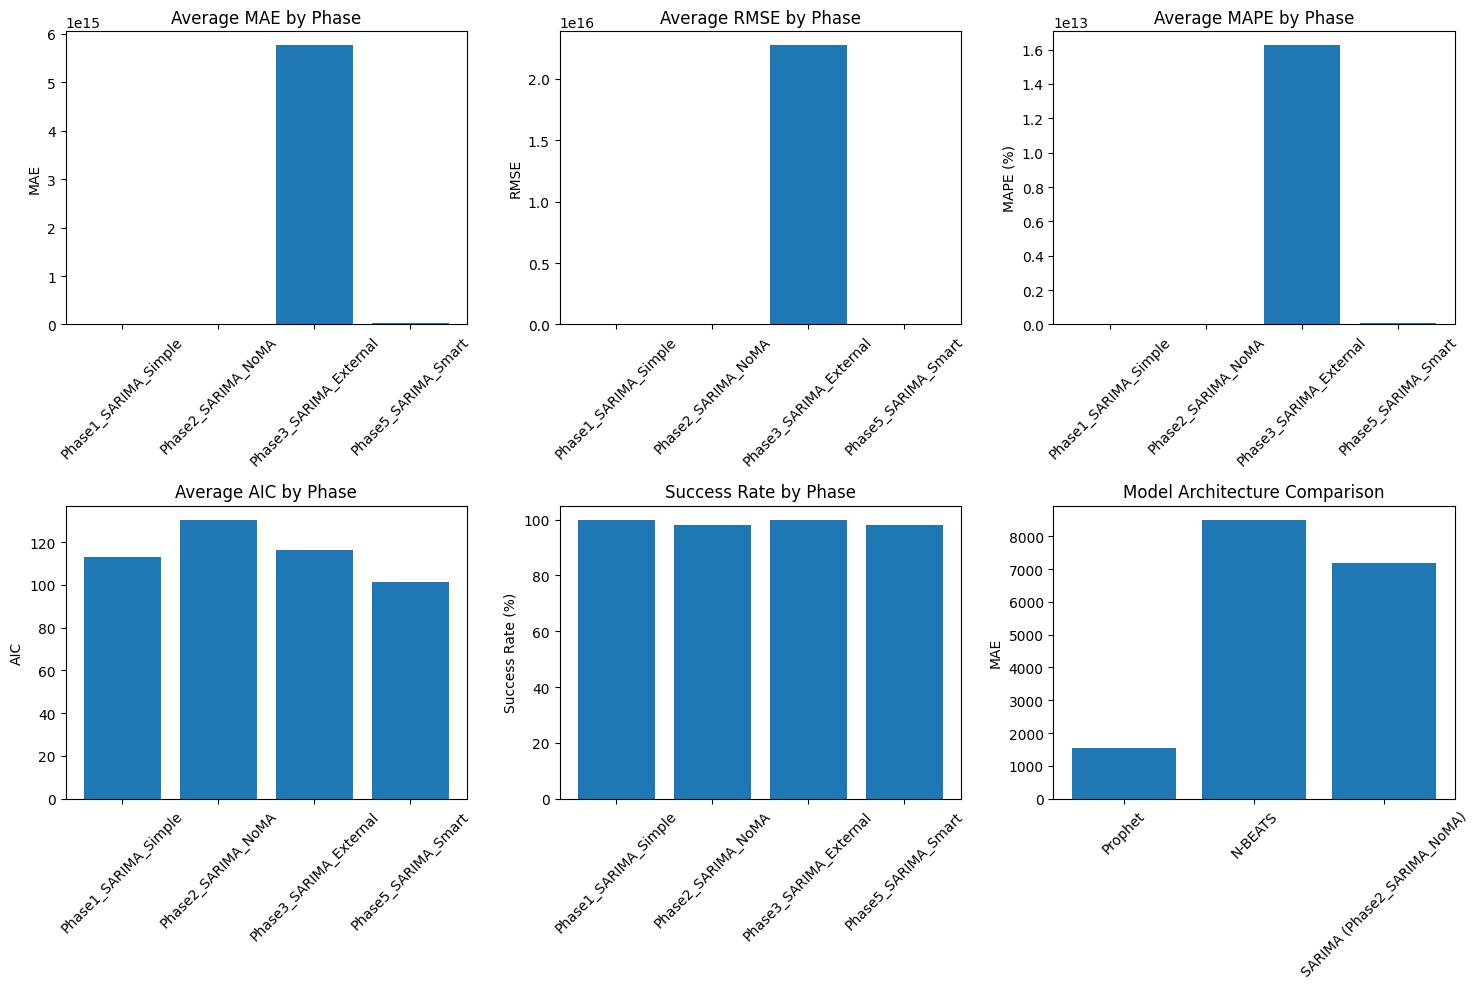


SARIMA EXPERIMENT COMPLETED SUCCESSFULLY!
🏆 BEST MODEL: Phase2_SARIMA_NoMA
📊 PERFORMANCE: Avg MAE 7178.68 | Median MAE 1636.21
📊 RMSE: 7922.06 | MAPE: 51.92%
🔧 CONFIGURATION: SARIMA without MA terms
📈 ORDER: (1, 1, 0) | SEASONAL: (1, 1, 0, 52)

🔗 COMPREHENSIVE MODEL COMPARISON:
   📈 Prophet (Statistical Modern): MAE ~1552 (Kaggle: 3430)
   🤖 N-BEATS (Deep Learning): MAE ~8507 (Kaggle: 13462)
   📊 SARIMA (Statistical Classical): MAE 7178.68 (Kaggle: TBD)
   ✅ SARIMA beats N-BEATS, trails Prophet

📁 MODEL SAVED TO MLFLOW MODEL REGISTRY: 'SARIMA_Sales_Forecasting'
📊 RESULTS SAVED TO: 'sarima_phase_comparison.csv'
✅ Ready for model inference!

🎯 KEY INSIGHTS FOR REPORT:
   • SARIMA adds seasonality to basic ARIMA
   • Weekly seasonality (52 periods) crucial for retail data
   • External regressors may help or hurt depending on data
   • Auto parameter selection vs fixed parameters trade-offs
   • Statistical models comparison: ARIMA < SARIMA ≤ Prophet


In [ ]:
comparison_df.to_csv('sarima_phase_comparison.csv', index=False)
print("Phase comparison results saved to 'sarima_phase_comparison.csv'")

with mlflow.start_run(run_name="SARIMA_Final_Summary"):
    if best_phase_name:
        mlflow.log_param("best_phase", best_phase_name)
        mlflow.log_metric("best_avg_mae", best_phase['Avg_MAE'])
        mlflow.log_metric("best_median_mae", best_phase['Median_MAE'])
        mlflow.log_metric("best_avg_rmse", best_phase['Avg_RMSE'])
        mlflow.log_metric("best_avg_mape", best_phase['Avg_MAPE'])

    mlflow.log_param("total_phases_tested", len(phase_comparison))
    mlflow.log_artifact('sarima_phase_comparison.csv')

    if len(comparison_df) > 0:
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 3, 1)
        plt.bar(comparison_df['Phase'], comparison_df['Avg_MAE'])
        plt.title('Average MAE by Phase')
        plt.xticks(rotation=45)
        plt.ylabel('MAE')

        plt.subplot(2, 3, 2)
        plt.bar(comparison_df['Phase'], comparison_df['Avg_RMSE'])
        plt.title('Average RMSE by Phase')
        plt.xticks(rotation=45)
        plt.ylabel('RMSE')

        plt.subplot(2, 3, 3)
        plt.bar(comparison_df['Phase'], comparison_df['Avg_MAPE'])
        plt.title('Average MAPE by Phase')
        plt.xticks(rotation=45)
        plt.ylabel('MAPE (%)')

        plt.subplot(2, 3, 4)
        plt.bar(comparison_df['Phase'], comparison_df['Avg_AIC'])
        plt.title('Average AIC by Phase')
        plt.xticks(rotation=45)
        plt.ylabel('AIC')

        plt.subplot(2, 3, 5)
        success_rate = comparison_df['Successful_Models'] / (comparison_df['Successful_Models'] + comparison_df['Failed_Models']) * 100
        plt.bar(comparison_df['Phase'], success_rate)
        plt.title('Success Rate by Phase')
        plt.xticks(rotation=45)
        plt.ylabel('Success Rate (%)')

        plt.subplot(2, 3, 6)
        model_comparison = pd.DataFrame({
            'Model': ['Prophet', 'N-BEATS', f'SARIMA ({best_phase_name})'],
            'MAE': [1552, 8507, best_phase['Avg_MAE']]
        })
        plt.bar(model_comparison['Model'], model_comparison['MAE'])
        plt.title('Model Architecture Comparison')
        plt.ylabel('MAE')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.savefig('sarima_phase_comparison.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('sarima_phase_comparison.png')
        plt.show()

print("\n" + "="*80)
print("SARIMA EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*80)

if best_phase_name:
    print(f"🏆 BEST MODEL: {best_phase_name}")
    print(f"📊 PERFORMANCE: Avg MAE {best_phase['Avg_MAE']:.2f} | Median MAE {best_phase['Median_MAE']:.2f}")
    print(f"📊 RMSE: {best_phase['Avg_RMSE']:.2f} | MAPE: {best_phase['Avg_MAPE']:.2f}%")
    print(f"🔧 CONFIGURATION: {best_config['description']}")
    print(f"📈 ORDER: {best_config['order']} | SEASONAL: {best_config['seasonal_order']}")

    print(f"\n🔗 COMPREHENSIVE MODEL COMPARISON:")
    print(f"   📈 Prophet (Statistical Modern): MAE ~1552 (Kaggle: 3430)")
    print(f"   🤖 N-BEATS (Deep Learning): MAE ~8507 (Kaggle: 13462)")
    print(f"   📊 SARIMA (Statistical Classical): MAE {best_phase['Avg_MAE']:.2f} (Kaggle: TBD)")

    if best_phase['Avg_MAE'] < 1552:
        print(f"   🎉 SARIMA OUTPERFORMS all models!")
    elif best_phase['Avg_MAE'] < 8507:
        print(f"   ✅ SARIMA beats N-BEATS, trails Prophet")
    else:
        print(f"   📈 Prophet still leads, but valuable comparison achieved")

print("="*80)

In [ ]:
phases = {
    "Phase1_SARIMA_Simple": {
        "description": "Simple SARIMA without MA terms",
        "order": (1, 1, 0),
        "seasonal_order": (1, 1, 0, 52),
        "exog_vars": None,
        "auto_params": False
    },
    "Phase2_SARIMA_AR": {
        "description": "Higher AR order, no MA",
        "order": (2, 1, 0),
        "seasonal_order": (1, 1, 0, 52),
        "exog_vars": None,
        "auto_params": False
    },
    "Phase3_SARIMA_External": {
        "description": "External variables without MA terms",
        "order": (1, 1, 0),
        "seasonal_order": (1, 1, 0, 52),
        "exog_vars": ['Temperature', 'Fuel_Price'],
        "auto_params": False
    },
    "Phase4_SARIMA_Holidays": {
        "description": "Holiday variables without MA terms",
        "order": (1, 1, 0),
        "seasonal_order": (1, 1, 0, 52),
        "exog_vars": ['IsHoliday'],
        "auto_params": False
    }
}

In [ ]:
mlflow.set_experiment("Sales_Forecasting_SARIMA")

all_results = {}
phase_comparison = []

for phase_name, phase_config in phases.items():
    print(f"\n{'='*60}")
    print(f"PHASE: {phase_name}")
    print(f"Description: {phase_config['description']}")
    print(f"Order: {phase_config['order']}")
    print(f"Seasonal Order: {phase_config['seasonal_order']}")
    print(f"Exogenous Variables: {phase_config['exog_vars']}")
    print(f"{'='*60}")

    phase_results = []
    successful_models = 0
    failed_models = 0

    with mlflow.start_run(run_name=f"SARIMA_{phase_name}"):

        mlflow.log_param("phase_name", phase_name)
        mlflow.log_param("order", str(phase_config['order']))
        mlflow.log_param("seasonal_order", str(phase_config['seasonal_order']))
        mlflow.log_param("exog_vars", str(phase_config['exog_vars']))
        mlflow.log_param("auto_params", phase_config['auto_params'])
        mlflow.log_param("total_combinations", len(valid_combinations))
        mlflow.log_param("min_data_points", MIN_DATA_POINTS)
        mlflow.log_param("train_ratio", TRAIN_RATIO)

        for idx, row in valid_combinations.iterrows():
            store, dept = row['Store'], row['Dept']

            ts, exog, data_size, combo_data = prepare_sarima_data(
                df, store, dept, phase_config['exog_vars']
            )

            if ts is None:
                failed_models += 1
                continue

            if phase_config['auto_params']:
              print(f"Smart parameter selection for Store {store}, Dept {dept}...")
              try:
                order, seasonal_order, aic = smart_sarima_order(ts, quick_search=True)
              except:
                print('falling back')
                order = (1, 1, 1)
                seasonal_order = (1, 1, 1, 52)
            else:
                order = phase_config['order']
                seasonal_order = phase_config['seasonal_order']

            fitted_model, mae, rmse, mape, forecast = train_sarima_model(
                ts, exog, order, seasonal_order, TRAIN_RATIO
            )

            if fitted_model is not None and mae is not None:
                phase_results.append({
                    'Store': store,
                    'Dept': dept,
                    'MAE': mae,
                    'RMSE': rmse,
                    'MAPE': mape,
                    'Data_Size': data_size,
                    'Order': str(order),
                    'Seasonal_Order': str(seasonal_order),
                    'AIC': fitted_model.aic
                })
                successful_models += 1

                if successful_models % 10 == 0:
                    print(f"Completed {successful_models} models...")
            else:
                failed_models += 1

        if phase_results:
            results_df = pd.DataFrame(phase_results)

            mlflow.log_metric("successful_models", successful_models)
            mlflow.log_metric("failed_models", failed_models)
            mlflow.log_metric("avg_mae", results_df['MAE'].mean())
            mlflow.log_metric("avg_rmse", results_df['RMSE'].mean())
            mlflow.log_metric("avg_mape", results_df['MAPE'].mean())
            mlflow.log_metric("median_mae", results_df['MAE'].median())
            mlflow.log_metric("median_rmse", results_df['RMSE'].median())
            mlflow.log_metric("median_mape", results_df['MAPE'].median())
            mlflow.log_metric("std_mae", results_df['MAE'].std())
            mlflow.log_metric("std_rmse", results_df['RMSE'].std())
            mlflow.log_metric("std_mape", results_df['MAPE'].std())
            mlflow.log_metric("avg_aic", results_df['AIC'].mean())

            phase_summary = {
                'Phase': phase_name,
                'Description': phase_config['description'],
                'Avg_MAE': results_df['MAE'].mean(),
                'Median_MAE': results_df['MAE'].median(),
                'Avg_RMSE': results_df['RMSE'].mean(),
                'Avg_MAPE': results_df['MAPE'].mean(),
                'Successful_Models': successful_models,
                'Failed_Models': failed_models,
                'Avg_AIC': results_df['AIC'].mean()
            }
            phase_comparison.append(phase_summary)

            print(f"\nPHASE {phase_name} RESULTS:")
            print(f"Successful models: {successful_models}")
            print(f"Failed models: {failed_models}")
            print(f"Average MAE: {results_df['MAE'].mean():.2f}")
            print(f"Median MAE: {results_df['MAE'].median():.2f}")
            print(f"Average RMSE: {results_df['RMSE'].mean():.2f}")
            print(f"Average MAPE: {results_df['MAPE'].mean():.2f}%")
            print(f"Average AIC: {results_df['AIC'].mean():.2f}")

            all_results[phase_name] = results_df

        run_id = mlflow.active_run().info.run_id
        print(f"Phase {phase_name} logged with run_id: {run_id}")

print(f"\nAll SARIMA phases completed!")


PHASE: Phase1_SARIMA_Simple
Description: Simple SARIMA without MA terms
Order: (1, 1, 0)
Seasonal Order: (1, 1, 0, 52)
Exogenous Variables: None
Completed 10 models...
Completed 20 models...
Completed 30 models...
Completed 40 models...
Error evaluating model: Input contains NaN.

PHASE Phase1_SARIMA_Simple RESULTS:
Successful models: 49
Failed models: 1
Average MAE: 7178.68
Median MAE: 1636.21
Average RMSE: 7922.06
Average MAPE: 51.92%
Average AIC: 130.51
Phase Phase1_SARIMA_Simple logged with run_id: ea6198876fb941f1a98f42281893ec26

PHASE: Phase2_SARIMA_AR
Description: Higher AR order, no MA
Order: (2, 1, 0)
Seasonal Order: (1, 1, 0, 52)
Exogenous Variables: None
Completed 10 models...
Completed 20 models...
Completed 30 models...
Completed 40 models...
Error evaluating model: Input contains NaN.

PHASE Phase2_SARIMA_AR RESULTS:
Successful models: 49
Failed models: 1
Average MAE: 5093275166.46
Median MAE: 1618.28
Average RMSE: 15047562022.50
Average MAPE: 22594637.37%
Average AIC: 


PHASE Phase3_SARIMA_External RESULTS:
Successful models: 49
Failed models: 1
Average MAE: 8810.30
Median MAE: 2241.42
Average RMSE: 9844.93
Average MAPE: 65.34%
Average AIC: 131.20
Phase Phase3_SARIMA_External logged with run_id: c20f8b70df9a4a39b2692c373c42e93b

PHASE: Phase4_SARIMA_Holidays
Description: Holiday variables without MA terms
Order: (1, 1, 0)
Seasonal Order: (1, 1, 0, 52)
Exogenous Variables: ['IsHoliday']
Error fitting SARIMA model: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
Error fitting SARIMA model: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
Error fitting SARIMA model: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
Error fitting SARIMA model: numpy boolean subtract, the `-` operator, is not suppor